<h2>OBSERVATIONAL ASTROPHYSICS – FALL 2019 Reduction Exercise: Part 5</h2>

The goal of this part is to produce a color-magnitude diagram for your cluster.  Do do this we need to detect stars, measure their flux, compare it to a known magnitude for that star, derive the magnitude zeropoint for that band, and convert all of your fluxes to magnitudes.  This will be broked into the following steps:

1. read in image with a valid astrometric header (the output image from the end of part 4);
2. Locate stars in this image and measure their flux;
3. Read in an ASCII file with a list of measured magnitudes for stars in that cluster;
4. Cross-match the two lists to find which object corresponds to which;
5. Compare the fluxes and magnitudes to determine the magnitude zeropoint of your image, i.e. what magnitude is a single count;
6. Use this to create magnitudes in each band
7. Produce a color-magnitude diagrame

The first cell below is a routine designed to read in one image

In [35]:
import os, glob, time
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import astropy.units as u

redpath = "/home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/"

A routine to display in image

In [2]:
def display_image(img, minclip=5, maxclip=95, label=None, cmap='Greys_r', 
                  srcs=None, projection=None, calibrated=False):
    """Simple wrapper to display an image.
    
    """
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ZScaleInterval as Interval
    from astropy.visualization.mpl_normalize import ImageNormalize

    #from astropy.visualization import simple_norm
    #norm = simple_norm(img, min_percent=minclip, max_percent=maxclip)

    interval = Interval(contrast=0.5)
    vmin, vmax = interval.get_limits(img)
    norm = ImageNormalize(interval=interval, stretch=Stretch(a=0.9))

    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': projection})
    im = ax.imshow(img, origin='lower', norm=norm, cmap=cmap,
                   vmin=vmin, vmax=vmax)
    if projection:
        ax.coords.grid(color='red')
        ax.coords['ra'].set_axislabel('Right Ascension')
        ax.coords['dec'].set_axislabel('Declination')      
    else:
        ax.set_xlabel('Column Number (pixels)')
        ax.set_ylabel('Row Number (pixels)')

    # Mark the locations of stars.
    if srcs:
        from photutils import CircularAperture
        pos = np.transpose((srcs['xcentroid'], srcs['ycentroid']))
        aps = CircularAperture(pos, r=12.)
        aps.plot(color='red', lw=1.5, alpha=0.6, axes=ax)
      
    # Make room for the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.28, 0.05, 0.45])
    c = plt.colorbar(im, cax=cax)
    if label:
        c.set_label(label)
    else:
        if calibrated:
            c.set_label(r'Intensity ($e^{-}/s$)')
        else:
            c.set_label('Intensity (ADU)')

<h3> Find the stars in your image</h3>

In [3]:
#filename should be the name of the combined image file (without path) that has the original header
#wcsfilename should be the name of the image that has the correct WCS header, e.g. one output
#by astrometry.net. 
def read_one_image(filename, wcsfilename, redpath):
    from astropy.table import Table
    from astropy.wcs import WCS

    # This joins the path and the filename
    imgfile = os.path.join('{}'.format(redpath), filename)
    wcsfile = os.path.join('{}'.format(redpath), wcsfilename)

    print('Reading {}'.format(imgfile))
    #this is the image and full header of the file.  
    img, hdr = fits.getdata(imgfile, header=True)
    wcshdr = fits.getheader(wcsfile)

    #this is only the section of the file that contains the WCS, which is the mapping between pixel 
    #and sky coordinate (RA,DEC)
    imgwcs = WCS(wcshdr)#, naxis=2)

    return img, hdr, imgwcs, imgfile

In [4]:
img_nova_B, hdr_nova_B, imgwcs_nova_B, imgfile_nova_B = read_one_image('nova_B_comb.fits','wnova_B_comb.fits',redpath)
img_nova_R, hdr_nova_R, imgwcs_nova_R, imgfile_nova_R = read_one_image('nova_R_comb.fits','wnova_R_comb.fits',redpath)
img_nova_V, hdr_nova_V, imgwcs_nova_V, imgfile_nova_V = read_one_image('nova_V_comb.fits','wnova_V_comb.fits',redpath)
img_ngc7128_B, hdr_ngc7128_B, imgwcs_ngc7128_B, imgfile_ngc7128_B = read_one_image('ngc7128_B_comb.fits','wngc7128_B_comb.fits',redpath)
img_ngc7128_V, hdr_ngc7128_V, imgwcs_ngc7128_V, imgfile_ngc7128_V = read_one_image('ngc7128_V_comb.fits','wngc7128_V_comb.fits',redpath)

Reading /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/nova_B_comb.fits
Reading /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/nova_R_comb.fits
Reading /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/nova_V_comb.fits
Reading /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/ngc7128_B_comb.fits
Reading /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/ngc7128_V_comb.fits


This is the same routine that we used in part 4.  It measures the background.

In [5]:
def get_sky_background(img, verbose=True):
    from astropy.stats import SigmaClip
    from photutils import Background2D, MedianBackground
    sigma_clip = SigmaClip(sigma=4.)
    bkg = Background2D(img, (100, 100), filter_size=(10, 10), sigma_clip=sigma_clip, 
                       bkg_estimator=MedianBackground())
    if verbose:
        print('Sky background median = {:.3f}, rms = {:.3f} electrons.'.format(bkg.background_median, bkg.background_rms_median))
    return bkg

This gets the background and subtracts it from the image to get a background subtracted image.  As in part 4 we check that the background looks correct.

In [6]:
#***********
bkg_nova_B = get_sky_background(img_nova_B, verbose=True)
img_nova_B_nosky = img_nova_B - bkg_nova_B.background

bkg_nova_R = get_sky_background(img_nova_R, verbose=True)
img_nova_R_nosky = img_nova_R - bkg_nova_R.background

bkg_nova_V = get_sky_background(img_nova_V, verbose=True)
img_nova_V_nosky = img_nova_V - bkg_nova_V.background

bkg_ngc7128_B = get_sky_background(img_ngc7128_B, verbose=True)
img_ngc7128_B_nosky = img_ngc7128_B - bkg_ngc7128_B.background

bkg_ngc7128_V = get_sky_background(img_ngc7128_V, verbose=True)
img_ngc7128_V_nosky = img_ngc7128_V - bkg_ngc7128_V.background

Sky background median = 3.572, rms = 0.074 electrons.
Sky background median = 6.174, rms = 0.119 electrons.
Sky background median = 3.751, rms = 0.087 electrons.
Sky background median = 3.139, rms = 0.063 electrons.
Sky background median = 3.354, rms = 0.067 electrons.


In [8]:
def qa_background(img,img_nosky,bkg):
    med, sig = bkg.background_median, bkg.background_rms_median
    vrange = (-3*sig, med+5*sig)
    fig, ax = plt.subplots(figsize=(7, 5))
    _ = ax.hist(img.flatten(), bins=100, range=vrange, label='Image w/ Background')
    #_ = ax.hist(bkg.background.flatten(), bins=50, range=(-sig, med+5*sig), label='Background')
    _ = ax.hist(img_nosky.flatten(), bins=100, range=vrange, label='Image w/o Background')
    ax.axvline(x=bkg.background_median, lw=2, ls='-', color='k')
    ax.set_xlabel('Intensity (e-/s)')
    ax.set_ylabel('Number')
    ax.legend(fontsize=12, frameon=False)

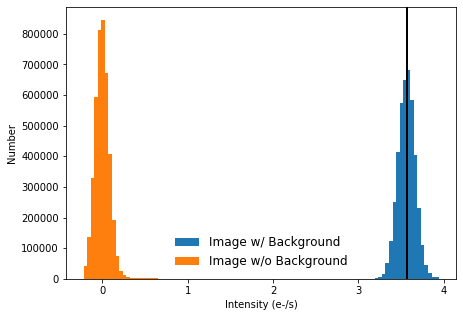

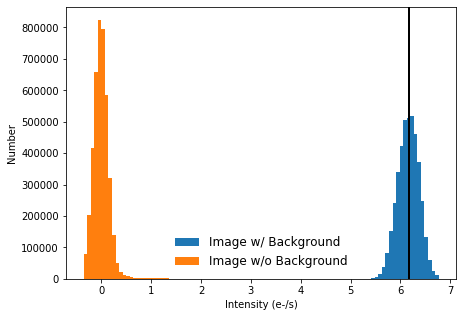

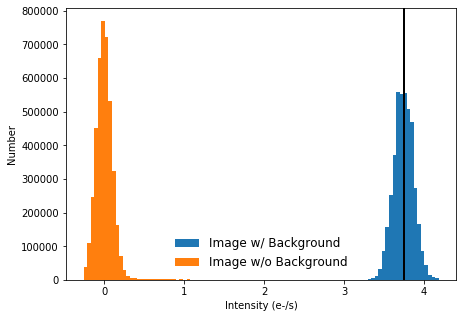

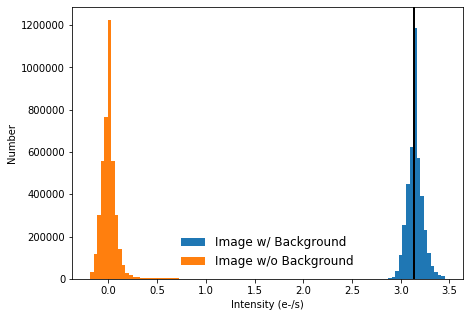

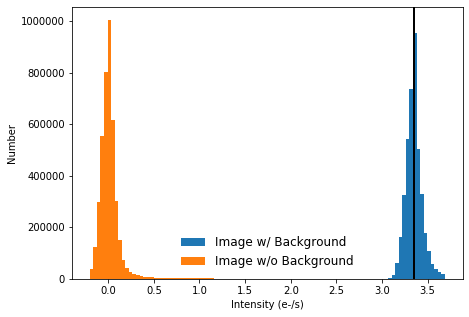

In [9]:
#***********
qa_background(img_nova_B, img_nova_B_nosky,bkg_nova_B)
qa_background(img_nova_R, img_nova_R_nosky,bkg_nova_R)
qa_background(img_nova_V, img_nova_V_nosky,bkg_nova_V)
qa_background(img_ngc7128_B, img_ngc7128_B_nosky,bkg_ngc7128_B)
qa_background(img_ngc7128_V, img_ngc7128_V_nosky,bkg_ngc7128_V)

This routine detects stars in the image.  It requires a zero background image.  There are many ways to measure object flux.  We are using the DAOStarfinder algorithm described (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html)

This code requires as input the FWHM of stars in the image in pixel units.  You can determine this using the *imexam* task.

You can use this by going to your image directory and typing *ipython* at the command line.  Once the interactive python environment loads you type the following set of commands:

*import imexam*
*viewer=imexam.connect()*
*viewer.load_fits('<filename>')*
*viewer.scale()*
    
You can then hit the "a" key and "r" key on bright isolated and unsaturated stars to find the FWHM.

If imexam doesn't work on your computer then just use the mean FWHM from all the individual observations for that band/target

This will need to be run once for each band

In [11]:
#this code outputs a file with all the detected stars.
#fwhm is for stars in the image in units of pixels
#nsigma is the detection threshold for each star
def find_stars(image, imgfile, fwhm=3.0, nsigma=3, sigma=None, 
               verbose=True, overwrite=False):
    from astropy.table import Table
    
    #this makes a file 
    starsfile = os.path.join(redpath, 'stars-{}'.format(os.path.basename(imgfile)))
    if not os.path.isfile(starsfile) or overwrite:
        from photutils import DAOStarFinder
        if sigma is None:
            sigma = np.std(image)

        daofind = DAOStarFinder(fwhm=fwhm, threshold=nsigma * sigma)
        srcs = daofind(image)
        # reverse-sort by flux 
        srcs.sort('flux')
        srcs.reverse()
        if verbose:
            print('Found {} sources'.format(len(srcs)))

        print('Writing {} stars to {}'.format(len(srcs), starsfile))
        srcs.write(starsfile, overwrite=True)
    else:
        srcs = Table.read(starsfile)
        print('Read {} stars from {}'.format(len(srcs), starsfile))
    return srcs

In [13]:
#***********
srcs_nova_B = find_stars(img_nova_B_nosky, imgfile_nova_B, sigma=bkg_nova_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_nova_B

Read 236 stars from /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/stars-nova_B_comb.fits


<Table length=236>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
   14 1756.6659687213119 ...  605.0626558725728     -6.954500873369921
   12 1755.5258117267135 ... 426.67302548190855     -6.575237968440392
   10  1756.305531471675 ...  419.6258703495269    -6.5571556375770506
   11 1756.6502743812703 ...  387.4801069812565     -6.470623527428167
   13   1757.02068172427 ...  374.6157369528696     -6.433965043437869
  147 210.55478258926888 ...  359.3192157168241     -6.388701107697356
  212  594.7903157231225 ... 355.86635557517445     -6.378217326860321
  205 2022.4047254190193 ... 269.56397491285105     -6.076654629321034
  139 264.24437723778107 ...  266.2207557284635     -6.063104779865248
  138  568.9971375551273 ... 238.28877611870917     -5.942758966708492
  ...                ... ...                ...                    ...
   79  766.9168761982809 ... 1.0079106885190652  -0.008555126896337646
   43 1177.0713272421208 ... 1.0067447687638584  -0.007298454022754368
  155  506.4681069753459 ... 1.0065531352089276  -0.007091764800207968
    3  1626.071553164636 ...   1.00641080445147  -0.006938226374968112
   58  655.9065277935892 ...  1.003537687407569  -0.003834217160417085
   93  535.4914176029154 ... 1.0032671473522956  -0.003541478046439235
   22  546.9198984049438 ...  1.002209252895914 -0.0023960201208310735
    4  837.7500460903757 ... 1.0017322445705044 -0.0018791335557246697
   21 1063.8023064177582 ...  1.001260665436237 -0.0013678880626578295
  236 1629.8953336154875 ... 1.0010914858126758 -0.0011844193928433945

In [14]:
srcs_nova_R = find_stars(img_nova_R_nosky, imgfile_nova_R, sigma=bkg_nova_R.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_nova_R

Read 3986 stars from /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/stars-nova_R_comb.fits


<Table length=3986>
  id      xcentroid      ...        flux                  mag          
int64      float64       ...      float64               float64        
----- ------------------ ... ------------------ -----------------------
 3664   573.804809692604 ...  1234.533503986878       -7.72875720184885
 2521 189.88343094720443 ...  1133.965989600788      -7.636500073009933
 2401  548.1541085314173 ... 1050.3974735430177       -7.55338417125162
  375 1735.4613777251923 ... 1047.4977112500924      -7.550382706798597
 2023 1767.0751600306178 ...  933.4183803040436     -7.4251908712368575
  349 1735.6548998904684 ...  904.7105471330775      -7.391274133399225
 2373   548.365860179783 ...   751.572813705927      -7.189927655450416
 2503 189.61318048069558 ...  730.1441249227821     -7.1585214875634815
 2385  243.4601282738527 ...  729.8347744055798      -7.158061380829518
 3176 105.78999110064372 ...  606.0089137271314      -6.956197530523124
  ...                ... ...                ...                     ...
 2660 134.35427817949025 ...  1.000457893706634  -0.0004970379886222843
 2235 1120.8045840761417 ... 1.0004215267207868 -0.00045757038973205666
 3893  901.7497769385388 ...   1.00029585750642 -0.00032117569739161525
 2127 1546.6651553399229 ...  1.000271857687459  -0.0002951256195491955
  567 1314.2918755717626 ... 1.0002422105034248  -0.0002629448700216282
 3014  302.2180088840727 ... 1.0002234967211752 -0.00024263136917673282
 3159 2015.3040720143135 ... 1.0001920098597448 -0.00020845204461186984
 3833  464.9099733012759 ... 1.0001749820375956 -0.00018996771341575923
 1326  94.48254032327006 ... 1.0001592000462498 -0.00017283549666806232
 2132   80.3141596274223 ... 1.0001394613719847 -0.00015140770321143396

In [15]:
srcs_nova_V = find_stars(img_nova_V_nosky, imgfile_nova_V, sigma=bkg_nova_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_nova_V

Read 602 stars from /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/stars-nova_V_comb.fits


<Table length=602>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
   40 1751.7071138583135 ...  777.6182183867706     -7.226916067206034
  546  590.5842271894631 ...  679.9593294179875     -7.081207342289214
  372  206.3170586197931 ...  652.6122772027652     -7.036638099124816
  548  589.7365254725385 ...  649.8536958143245     -7.032038982944106
  350  260.0499163959595 ...  647.2837871158176     -7.027736822834809
  351  259.1431953542591 ...   637.858006542015     -7.011810028156365
  373  205.6313917283514 ...  618.3001854839487     -6.977998441957375
  374 205.45324473989857 ...  613.6427602714983     -6.969789036995885
   37  1751.094566773677 ...  585.0037155031937      -6.91789656100635
  346  563.8704375559385 ...  571.7051822674924     -6.892930322323224
  ...                ... ...                ...                    ...
  398 185.13854344661598 ... 1.0034836428142642 -0.0037757442675254342
  480   1549.42121436085 ... 1.0032806249352013  -0.003556063395381009
  318 1099.7145030203337 ... 1.0026067413268382  -0.002826550989824185
  600  673.8605507724492 ... 1.0022671547263409  -0.002458745841517796
   15  1713.264666397728 ... 1.0016340713856222  -0.001772722481125556
  133 1313.4388365920413 ... 1.0014412454604749 -0.0015636858193141488
  184  94.12539200909403 ... 1.0012796112906577 -0.0013884321688755568
  399  92.32079374284613 ...  1.001121480856566 -0.0012169501032718096
  380 265.18553269419675 ... 1.0007038613687014 -0.0007639389491007118
   41  688.3682216612915 ... 1.0005509842922589 -0.0005980588489685743

In [16]:
srcs_ngc7128_B = find_stars(img_ngc7128_B_nosky, imgfile_ngc7128_B, sigma=bkg_ngc7128_B.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_B

Read 627 stars from /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/stars-ngc7128_B_comb.fits


<Table length=627>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  468  710.1544383510613 ... 1317.4366949011587      -7.79932438947306
   61  538.8103205341885 ... 1004.9611160564609      -7.50537314591165
  475  838.3087713512969 ...  869.2826778944836     -7.347902563926069
  214 1511.4545605045657 ...  742.4892489433375     -7.176725423901116
  276 1686.9025331050807 ...  619.8575882494224     -6.980729805432224
  360   900.712128224382 ... 442.87472246947146     -6.615702232969145
  423  933.7354561886189 ... 435.30820937093887     -6.596992143719822
  417  730.4462752881259 ...  414.1025990775372     -6.542769890802492
  337  361.0309722730488 ...  388.3992117106465     -6.473195849497849
  221 1528.4250249458837 ...  370.9138974984977     -6.423182764730507
  ...                ... ...                ...                    ...
   93  563.6567873690419 ... 1.0310883464467355   -0.03323969601798838
  408 1021.8301723015194 ... 1.0280011584749043   -0.02998401018650529
   81 1092.5749531755093 ... 1.0279133271488383  -0.029891242076404846
  353  855.2273650458292 ... 1.0267442357725562  -0.028655683418076297
  129 1469.0540700829517 ... 1.0207050179010833   -0.02225062454220762
  611  509.5741381350666 ... 1.0202546874856895   -0.02177149696047147
  196  392.5678723617531 ... 1.0174787615088214  -0.018813381706807818
  441  795.2301844615317 ...  1.001660979913428 -0.0018018899897641264
  185 1040.5899308417045 ... 1.0016154226840828  -0.001752507754508995
  161  728.9750698711262 ...  1.001165628037581 -0.0012648275455833555

In [17]:
srcs_ngc7128_V = find_stars(img_ngc7128_V_nosky, imgfile_ngc7128_V, sigma=bkg_ngc7128_V.background_rms_median, nsigma=5, 
                  verbose=True, overwrite=False)
srcs_ngc7128_V

Read 1643 stars from /home/l943z843/RFSLAB/USER_DPT/l943z843/ASTR596/Data/Reduced2/20191106/stars-ngc7128_V_comb.fits


<Table length=1643>
  id      xcentroid      ...        flux                 mag          
int64      float64       ...      float64              float64        
----- ------------------ ... ------------------ ----------------------
  191   866.944693845182 ...  2217.646739387503     -8.364730915676335
  630 1839.8060536438882 ... 2212.2446110802275     -8.362082864638792
  777  2015.347209200285 ... 2159.5655547436363     -8.335915979550258
  364 169.74805681423283 ... 2141.6447114204957     -8.326868562752596
 1215  1167.199024395846 ...  1926.084339606043      -8.21168825035597
 1088 1237.3432709728927 ... 1812.8628861183352     -8.145912394885684
  774  2015.225120910743 ... 1719.8200603420044      -8.08870752586112
 1091 1262.4473672922547 ... 1666.0483299417479      -8.05421898895929
  642 1856.7797214723637 ... 1577.2911410295414     -7.994779660196777
  768  2015.220903799948 ... 1567.7092674788828     -7.988163814179839
  ...                ... ...                ...                    ...
   11 2026.5237055347718 ... 1.0096481451196688    -0.0104251293669952
  868  620.6856348490696 ... 1.0082133755348042  -0.008881136847834755
  801 1299.5489027207611 ... 1.0076838070959484  -0.008310699381933117
  344 1010.3432272914346 ...  1.007041451619452  -0.007618368139475336
  388  883.5321292506982 ... 1.0067715518312779  -0.007327338165064054
 1579 1572.2703194797696 ... 1.0067181026394398  -0.007269695233968393
 1627 1483.9863017946636 ... 1.0039497348313393  -0.004279923377443743
   78  451.7437717835954 ... 1.0021495456313365  -0.002331334757207014
  558  1366.307636097193 ... 1.0014293313269456 -0.0015507687529084052
   25  853.9243672281976 ...  1.001151519645627 -0.0012495272801352443

<h3> Use stars from Pan-STARRS</h3>

We will be using the large survey called Pan-STARRS (https://panstarrs.stsci.edu/).  Pan-STARRS uses SDSS filters (*griz*), which are different from the "Johnson" *BVR* filters that we are using.  But there are transformation between these filters such that if we know the Pan-STARRS magnitudes of a given object, we can determine its B-V color.

This routine sends a request to a catalog server at a remote location and pulls back all the photometry

In [19]:
def get_panstarrs_catalog(imgwcs, radius=0.2, rfaint=17, region=False):
    from astroquery.mast import Catalogs
    ra0, dec0 = imgwcs.wcs.crval
    print('Querying Pan-STARRS catalog with radius={:.3f} deg and central coordinates RA,Dec={:.5f},{:.5f}'.format(
        radius, ra0, dec0))
    if region:
        allcat = Catalogs.query_region('{} {}'.format(ra0, dec0), radius=radius,
                                       catalog='PANSTARRS', data_release='dr2', 
                                       table='mean')#, rMeanPSFMag=[12, 22])
    else:
        allcat = Catalogs.query_criteria(coordinates='{} {}'.format(ra0, dec0), radius=radius,
                                         catalog='PANSTARRS', data_release='dr2', 
                                         table='mean',
                                         columns=['objID', 'raMean', 'decMean',
                                                  'gMeanPSFMag', 'rMeanPSFMag', 'iMeanPSFMag', 'zMeanPSFMag'],
                                         gMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         rMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         iMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         zMeanPSFMag=[('lte', 18), ('gte', 12)],
                                         sort_by=[("asc", "rMeanPSFMag")])
    

    #we limit ourselves to bright objects so that we know that they will have high Signal-to-Noise
    rmag = allcat['rMeanPSFMag']
    good = np.isfinite(rmag) * rmag < rfaint
    cat = allcat[good]
    print('Keeping {}/{} Pan-STARRS sources with rmag< {}.'.format(len(cat), len(allcat),rfaint))
    
    #make B and V-band magnitudes using the transformations published in Tonry et al. (2012)
    #https://ui.adsabs.harvard.edu/abs/2012ApJ...750...99T/abstract
    cat['B'] = 0.213 + 0.587 * (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['gMeanPSFMag'] 
    cat['V'] = 0.006 + 0.474 *  (cat['gMeanPSFMag'] - cat['rMeanPSFMag']) + cat['rMeanPSFMag'] 
    
    return cat

In [20]:
%time refcat_nova_B = get_panstarrs_catalog(imgwcs_nova_B, radius=0.2)
refcat_nova_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=11.43781,41.88899


Keeping 244/306 Pan-STARRS sources with rmag< 17.
CPU times: user 377 ms, sys: 71.7 ms, total: 449 ms
Wall time: 23.9 s


<Table masked=True length=244>
      objID           raMean   ...         B                  V         
      int64          float64   ...      float64            float64      
------------------ ----------- ... ------------------ ------------------
158230116346469361 11.63463808 ... 12.816315893173218 12.311032283782959
158190112505370928 11.25054054 ... 13.302907295227051 12.694114227294921
158090112615613324 11.26158965 ... 14.064754969596862 13.011429971694946
158170112257638375 11.22570264 ... 14.003811842918395 13.044424242019653
158070113119041568 11.31192454 ... 13.685842476844787 13.071484281539917
158210115042413714 11.50424847 ...  14.09989005279541 13.195150665283203
158330115058467558 11.50585428 ...  13.39191865348816 13.058036296844483
158320114124286014 11.41247673 ... 14.179295783996581 13.310951034545898
158080113191887869 11.31922344 ... 13.953713990211487 13.277028066635133
158220113364604669 11.33645339 ...  14.38134712791443 13.426633045196533
               ...         ... ...                ...                ...
158130113969946713 11.39706167 ...  18.07638397026062  17.20881831741333
158330116924372878 11.69244198 ... 18.012890949249268  17.19195858001709
158410115986683433 11.59868919 ... 18.047432876586914 17.202906829833985
158250113058616194 11.30586629 ... 18.173538284301756 17.248988189697265
158280115281875626 11.52821125 ... 18.595150648117066 17.378770496368407
158380116686523686 11.66868025 ...  18.53388628768921  17.36503102874756
158440113558749856 11.35589774 ... 17.926808219909667 17.191355697631835
158130114021155975 11.40213581 ...  18.40371608543396 17.336812091827394
158240115849926644 11.58499626 ... 17.828482271194456 17.186744243621828
158050115426694975  11.5426601 ... 17.753588172912597  17.16549742126465

In [21]:
%time refcat_nova_R = get_panstarrs_catalog(imgwcs_nova_R, radius=0.2)
refcat_nova_R

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=11.43777,41.88876
Keeping 244/306 Pan-STARRS sources with rmag< 17.
CPU times: user 26.9 ms, sys: 0 ns, total: 26.9 ms
Wall time: 8.62 s


<Table masked=True length=244>
      objID           raMean   ...         B                  V         
      int64          float64   ...      float64            float64      
------------------ ----------- ... ------------------ ------------------
158230116346469361 11.63463808 ... 12.816315893173218 12.311032283782959
158190112505370928 11.25054054 ... 13.302907295227051 12.694114227294921
158090112615613324 11.26158965 ... 14.064754969596862 13.011429971694946
158170112257638375 11.22570264 ... 14.003811842918395 13.044424242019653
158070113119041568 11.31192454 ... 13.685842476844787 13.071484281539917
158210115042413714 11.50424847 ...  14.09989005279541 13.195150665283203
158330115058467558 11.50585428 ...  13.39191865348816 13.058036296844483
158320114124286014 11.41247673 ... 14.179295783996581 13.310951034545898
158080113191887869 11.31922344 ... 13.953713990211487 13.277028066635133
158220113364604669 11.33645339 ...  14.38134712791443 13.426633045196533
               ...         ... ...                ...                ...
158130113969946713 11.39706167 ...  18.07638397026062  17.20881831741333
158330116924372878 11.69244198 ... 18.012890949249268  17.19195858001709
158410115986683433 11.59868919 ... 18.047432876586914 17.202906829833985
158250113058616194 11.30586629 ... 18.173538284301756 17.248988189697265
158280115281875626 11.52821125 ... 18.595150648117066 17.378770496368407
158380116686523686 11.66868025 ...  18.53388628768921  17.36503102874756
158440113558749856 11.35589774 ... 17.926808219909667 17.191355697631835
158130114021155975 11.40213581 ...  18.40371608543396 17.336812091827394
158240115849926644 11.58499626 ... 17.828482271194456 17.186744243621828
158050115426694975  11.5426601 ... 17.753588172912597  17.16549742126465

In [22]:
%time refcat_nova_V = get_panstarrs_catalog(imgwcs_nova_V, radius=0.2)
refcat_nova_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=11.42044,41.90484
Keeping 245/310 Pan-STARRS sources with rmag< 17.
CPU times: user 21.1 ms, sys: 4.11 ms, total: 25.2 ms
Wall time: 9.42 s


<Table masked=True length=245>
      objID           raMean   ...         B                  V         
      int64          float64   ...      float64            float64      
------------------ ----------- ... ------------------ ------------------
158230116346469361 11.63463808 ... 12.816315893173218 12.311032283782959
158190112505370928 11.25054054 ... 13.302907295227051 12.694114227294921
158090112615613324 11.26158965 ... 14.064754969596862 13.011429971694946
158170112257638375 11.22570264 ... 14.003811842918395 13.044424242019653
158210115042413714 11.50424847 ...  14.09989005279541 13.195150665283203
158070113119041568 11.31192454 ... 13.685842476844787 13.071484281539917
158460112728996510 11.27293783 ... 13.728125076293946 13.103750076293945
158330115058467558 11.50585428 ...  13.39191865348816 13.058036296844483
158320114124286014 11.41247673 ... 14.179295783996581 13.310951034545898
158080113191887869 11.31922344 ... 13.953713990211487 13.277028066635133
               ...         ... ...                ...                ...
158360114652652891 11.46530952 ... 18.141047258377075 17.224065227508547
158320113319682519 11.33199632 ...  17.80016596221924 17.122812393188475
158260115951685303 11.59518325 ... 18.554329650878906 17.349746337890625
158130113969946713 11.39706167 ...  18.07638397026062  17.20881831741333
158410115986683433 11.59868919 ... 18.047432876586914 17.202906829833985
158250113058616194 11.30586629 ... 18.173538284301756 17.248988189697265
158280115281875626 11.52821125 ... 18.595150648117066 17.378770496368407
158440113558749856 11.35589774 ... 17.926808219909667 17.191355697631835
158130114021155975 11.40213581 ...  18.40371608543396 17.336812091827394
158240115849926644 11.58499626 ... 17.828482271194456 17.186744243621828

In [23]:
%time refcat_ngc7128_B = get_panstarrs_catalog(imgwcs_ngc7128_B, radius=0.2)
refcat_ngc7128_B

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=326.00712,53.81114
Keeping 850/873 Pan-STARRS sources with rmag< 17.
CPU times: user 19.2 ms, sys: 7.93 ms, total: 27.2 ms
Wall time: 4.66 s


<Table masked=True length=850>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
172473260768521639 326.07689699 ... 12.996903435707093  12.49050637626648
172353260800752122 326.08018881 ... 13.394347136497498  12.65199419593811
172503258801023374 325.88018571 ... 13.518980298042298 12.710960340499877
172493261417666169 326.14181906 ... 13.128206895828248 12.630714252471924
172643260773104920 326.07735979 ... 13.424496117591858 12.763392126083374
172553259686507433 325.96868718 ... 13.459410614013672 12.773820274353028
172473259798384953 325.97983039 ... 13.340492380142212 12.781784397125245
172633258688450529 325.86897433 ... 13.562148631095885  12.90549631690979
172743259826877794 325.98279481 ... 14.018875129699707 13.116250129699708
172473259640020189 325.96395434 ...  13.78830311012268  13.05930626296997
               ...          ... ...                ...                ...
172363259058639985 325.90584764 ...  18.49352724647522  17.35227578353882
172453259870809010 325.98705102 ...  18.37328247833252  17.31895654296875
172393258941603698 325.89413827 ... 18.567522493362425 17.377742015838624
172403260420846772 326.04209213 ...  18.40174561882019 17.328719242095946
172483260826960724 326.08266776 ... 18.354912998199463 17.316835578918457
172683257728582538 325.77285876 ... 18.689186195373534 17.424389541625978
172553262697941835 326.26978045 ... 18.772572204589842  17.45357420349121
172523260536869365 326.05368032 ... 18.661042865753174 17.431974266052247
172453257754659558 325.77545628 ...  18.75739816093445 17.462997959136963
172493259703374524  325.9703144 ... 18.561794416427613 17.407521213531496

In [24]:
%time refcat_ngc7128_V = get_panstarrs_catalog(imgwcs_ngc7128_V, radius=0.2)
refcat_ngc7128_V

Querying Pan-STARRS catalog with radius=0.200 deg and central coordinates RA,Dec=326.08522,53.77941
Keeping 887/911 Pan-STARRS sources with rmag< 17.
CPU times: user 27.4 ms, sys: 440 µs, total: 27.8 ms
Wall time: 3.3 s


<Table masked=True length=887>
      objID           raMean    ...         B                  V         
      int64          float64    ...      float64            float64      
------------------ ------------ ... ------------------ ------------------
172473260768521639 326.07689699 ... 12.996903435707093  12.49050637626648
172353260800752122 326.08018881 ... 13.394347136497498  12.65199419593811
172503258801023374 325.88018571 ... 13.518980298042298 12.710960340499877
172493261417666169 326.14181906 ... 13.128206895828248 12.630714252471924
172553259686507433 325.96868718 ... 13.459410614013672 12.773820274353028
172643260773104920 326.07735979 ... 13.424496117591858 12.763392126083374
172473259798384953 325.97983039 ... 13.340492380142212 12.781784397125245
172633258688450529 325.86897433 ... 13.562148631095885  12.90549631690979
172553264163170669 326.41632148 ... 13.612649194717408 12.930398143768311
172743259826877794 325.98279481 ... 14.018875129699707 13.116250129699708
               ...          ... ...                ...                ...
172483260826960724 326.08266776 ... 18.354912998199463 17.316835578918457
172413263580446644 326.35800778 ... 18.742757459640504  17.43288571548462
172363262159768774  326.2159726 ... 18.674889432907104  17.41387787246704
172573263859626362 326.38594763 ...  18.53606314086914 17.373886459350587
172553263777748239 326.37777166 ...   18.7285239238739  17.43957527542114
172553262697941835 326.26978045 ... 18.772572204589842  17.45357420349121
172523263433159004 326.34331238 ...   18.7647651386261 17.460569972991944
172523260536869365 326.05368032 ... 18.661042865753174 17.431974266052247
172453257754659558 325.77545628 ...  18.75739816093445 17.462997959136963
172493259703374524  325.9703144 ... 18.561794416427613 17.407521213531496

We need to match the Pan-STARRS catalog against ours.  First we need to compute the nearest Pan-STARRS star to each of ours and look at the distribution of distances to find the optimal match.

In [26]:
def sep_check(imgwcs,srcs,refcat):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    
    #this makes an instance of a SkyCoord class containing the RAs and Decs from Pan-STARRS objects
    refcoord = SkyCoord(ra=refcat['raMean']*u.deg, dec=refcat['decMean']*u.deg)
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars = imgwcs.all_pix2world(srcs['xcentroid']+1, srcs['ycentroid']+1, 1)
    #this does the same from our targets 
    coord = SkyCoord(ra=radec_stars[0]*u.deg, dec=radec_stars[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord.match_to_catalog_sky(refcoord)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    return refcoord, coord

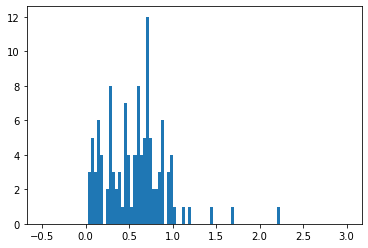

In [27]:
refcoord_nova_B, coord_nova_B = sep_check(imgwcs_nova_B,srcs_nova_B,refcat_nova_B)

In [28]:
refcoord_nova_R, coord_nova_R = sep_check(imgwcs_nova_R,srcs_nova_R,refcat_nova_R)

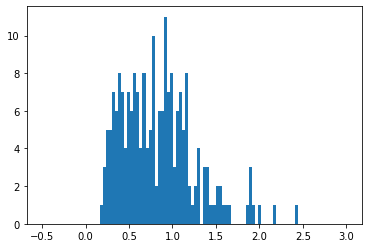

In [29]:
refcoord_nova_V, coord_nova_V = sep_check(imgwcs_nova_V,srcs_nova_V,refcat_nova_V)

In [30]:
refcoord_ngc7128_B, coord_ngc7128_B = sep_check(imgwcs_ngc7128_B,srcs_ngc7128_B,refcat_ngc7128_B)

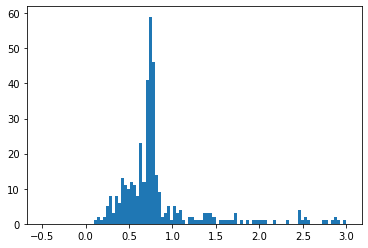

In [31]:
refcoord_ngc7128_V, coord_ngc7128_V = sep_check(imgwcs_ngc7128_V,srcs_ngc7128_V,refcat_ngc7128_V)

It looks like the optimal match is less than 1.0 arcsec.  The following routine matches to within this tolerance

In [36]:
#take two lists of coordinates 
def match_src_ref(refcoord, coord, srcs, img, radasec = 1.0):
    rad = radasec * u.arcsec

    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_ref, indx, d2d, _ = coord.search_around_sky(refcoord, rad)
    nmatch = len(indx_ref)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs), rad))
    display_image(img, srcs=srcs[indx], calibrated=True)
    return indx, indx_ref

Found 109/236 stars within 1.0 arcsec
Found 84/3986 stars within 1.0 arcsec
Found 145/602 stars within 1.0 arcsec
Found 369/627 stars within 1.0 arcsec
Found 316/1643 stars within 1.0 arcsec


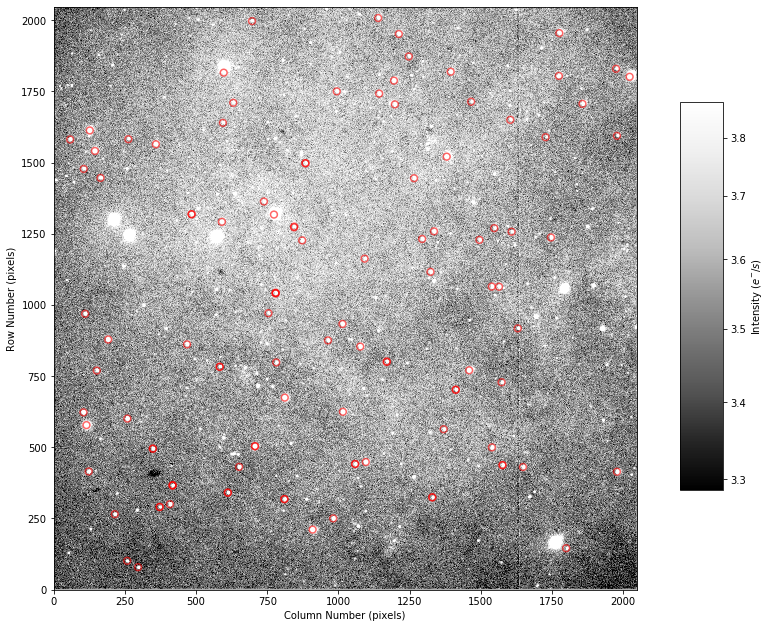

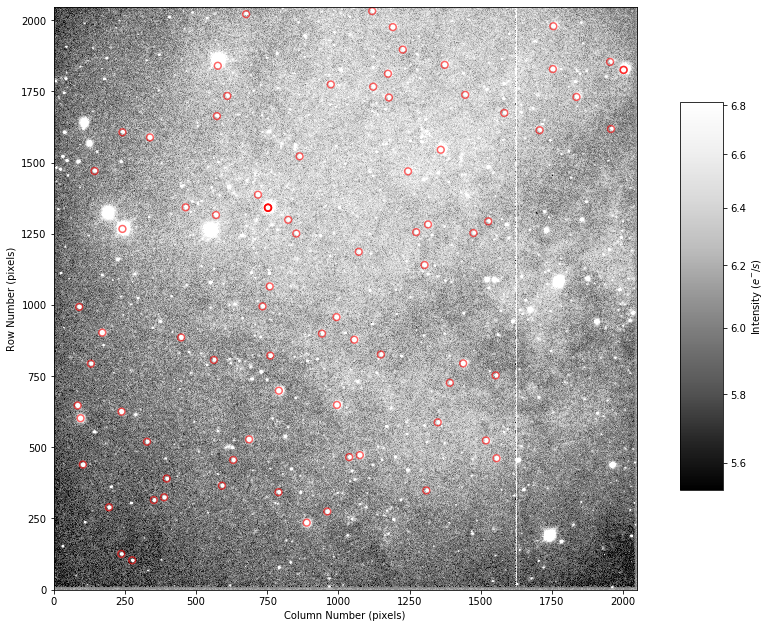

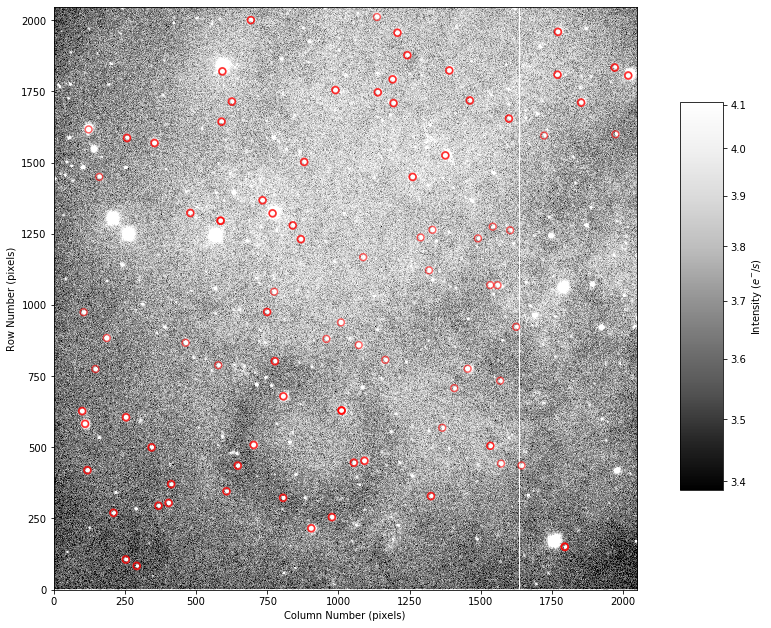

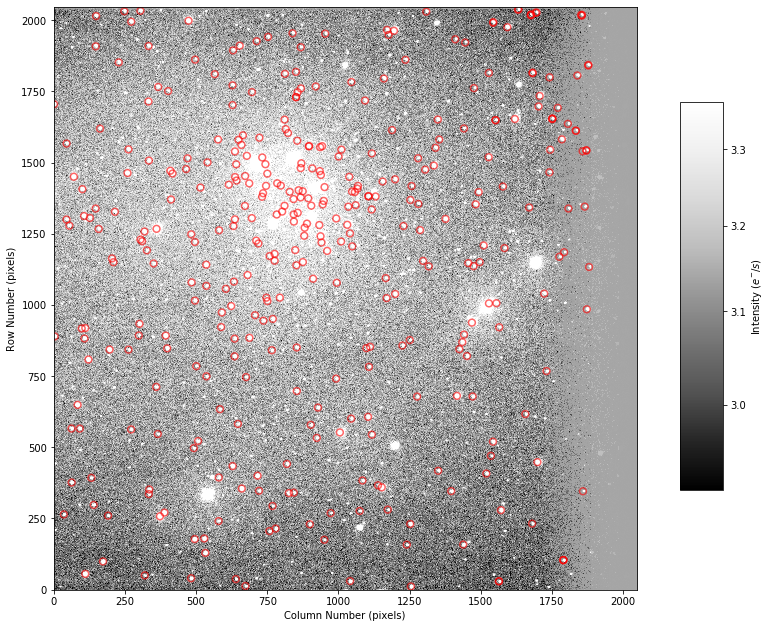

In [37]:
indx_nova_B, indx_ref_nova_B = match_src_ref(refcoord_nova_B, coord_nova_B, srcs_nova_B, img_nova_B)
indx_nova_R, indx_ref_nova_R = match_src_ref(refcoord_nova_R, coord_nova_R, srcs_nova_R, img_nova_R)
indx_nova_V, indx_ref_nova_V = match_src_ref(refcoord_nova_V, coord_nova_V, srcs_nova_V, img_nova_V)
indx_ngc7128_B, indx_ref_ngc7128_B = match_src_ref(refcoord_ngc7128_B, coord_ngc7128_B, srcs_ngc7128_B, img_ngc7128_B)
indx_ngc7128_V, indx_ref_ngc7128_V = match_src_ref(refcoord_ngc7128_V, coord_ngc7128_V, srcs_ngc7128_V, img_ngc7128_V)

Now let's calculate the zeropoints for each image.  To compare our objects to those from Pan-STARRS we will need to correct for the effects of airmass.

We start by specifying the atmospheric extinction coefficient for each object.  This says for a typical atmosphere, how much the magnitude changes for an increase in airmass of 1.  We could have measured this using mutliple standard stars but will just assume a cannonical value for now.

In [38]:
def zp_meas(srcs, refcat, indx, indx_ref, hdr):
    kext = {'B': 0.4, 'V': 0.2}
    import numpy.ma as ma

    #this consists of the instrumental magnitude, which is the magnitude, including an airmass correction
    #but without a true zeropoint.  The second term says how the magnitude 
    #m(inst) = -2.5 * log(flux) - (sec z) * k
    instmag = srcs['mag'][indx].data - hdr['AIRMASS'] * kext[hdr['FILTER']]

    #the Pan-STARRS magnitudes for the same objects, as indicated using the indx_ref array
    psmag = refcat[hdr['FILTER']][indx_ref].data

    #calculate the median zeropoint defined as
    #psmag = -2.5 * log(flux) - (sec z) * k + ZP = m(inst) + ZP
    medzp = np.median(psmag - instmag)
    print(hdr['FILTER'],'zeropoint = ', medzp)
    print('Airmass in {} was {}'.format(hdr['FILTER'], hdr['AIRMASS']))
    return medzp

In [44]:
ZPB_nova = zp_meas(srcs_nova_B,refcat_nova_B, indx_nova_B, indx_ref_nova_B,hdr_nova_B)
#ZPV = zp_meas(srcs_nova_R,refcat_nova_R, indx_nova_R, indx_ref_nova_R,hdr_nova_R)
#R isn't needed for the CMDs and I was geting an error that just said R_John that I couldn't figure out so I don't use R after here
ZPV_nova = zp_meas(srcs_nova_V,refcat_nova_V, indx_nova_V, indx_ref_nova_V,hdr_nova_V)
ZPB_ngc7128 = zp_meas(srcs_ngc7128_B,refcat_ngc7128_B, indx_ngc7128_B, indx_ref_ngc7128_B,hdr_ngc7128_B)
ZPV_ngc7128 = zp_meas(srcs_ngc7128_V,refcat_ngc7128_V, indx_ngc7128_V, indx_ref_ngc7128_V,hdr_ngc7128_V)

B zeropoint =  19.071584249293142
Airmass in B was 1.098645
V zeropoint =  18.861598459129844
Airmass in V was 1.129516
B zeropoint =  20.10487910836556
Airmass in B was 1.163366
V zeropoint =  20.46181354768664
Airmass in V was 1.217104


Now match the B and V-band catalogs together for this cluster, apply the zeropoints, and plot a CMD!

In [45]:
def make_CMD(img_B,imgwcs_B,srcs_B,imgwcs_V,srcs_V, hdr_B, hdr_V, ZPB, ZPV, radasec = 1.0):
    import astropy.units as u
    from astropy.coordinates import SkyCoord
    import numpy.ma as ma
    kext = {'B': 0.4, 'V': 0.2}
    rad = radasec * u.arcsec
    
    #This uses the WCS to convert the x and y positions of stars in our image to RA-DEC
    radec_stars_B = imgwcs_B.all_pix2world(srcs_B['xcentroid']+1, srcs_B['ycentroid']+1, 1)
    radec_stars_V = imgwcs_V.all_pix2world(srcs_V['xcentroid']+1, srcs_V['ycentroid']+1, 1)
    #this makes an instance of a SkyCoord class containing the RAs and Decs from the B-band
    coord_B = SkyCoord(ra=radec_stars_B[0]*u.deg, dec=radec_stars_B[1]*u.deg)
    coord_V = SkyCoord(ra=radec_stars_V[0]*u.deg, dec=radec_stars_V[1]*u.deg)

    #this calculates the separations.  The "_" are values that are thrown away
    _, sep2d, _ = coord_B.match_to_catalog_sky(coord_V)

    #plot the histograms
    _ = plt.hist(sep2d.arcsec, bins=100, range=(-0.5, 3))
    plt.xlabel('Sep between B and V sources [arcsec]',fontsize=14)
    plt.ylabel('N',fontsize=14)


    #find the indices of the reference and source list that correspond to matching objects such that
    #the first index in each list corresponds to the first matching object
    indx_B, indx_V, d2d, _ = coord_V.search_around_sky(coord_B, rad)
    nmatch = len(indx_B)
    print('Found {}/{} stars within {}'.format(nmatch, len(srcs_B), rad))
    display_image(img_B, srcs=srcs_B[indx_B], calibrated=True)
    
    #make the B and V-band magnitudes
    magB = srcs_B['mag'][indx_B].data + ZPB - hdr_B['AIRMASS'] * kext[hdr_B['FILTER']]
    magV = srcs_V['mag'][indx_V].data + ZPV - hdr_V['AIRMASS'] * kext[hdr_V['FILTER']]
    #print(magB)
    #print(magV)
    #print(magB-magV)

    #plot the CMD!
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(magB-magV, magV, 'ro',alpha=0.7)
    ax.set_ylim(19,10)
    ax.set_xlabel('B-V',fontsize=18)
    ax.set_ylabel('V',fontsize=18)
    plt.show


Found 380/236 stars within 1.0 arcsec


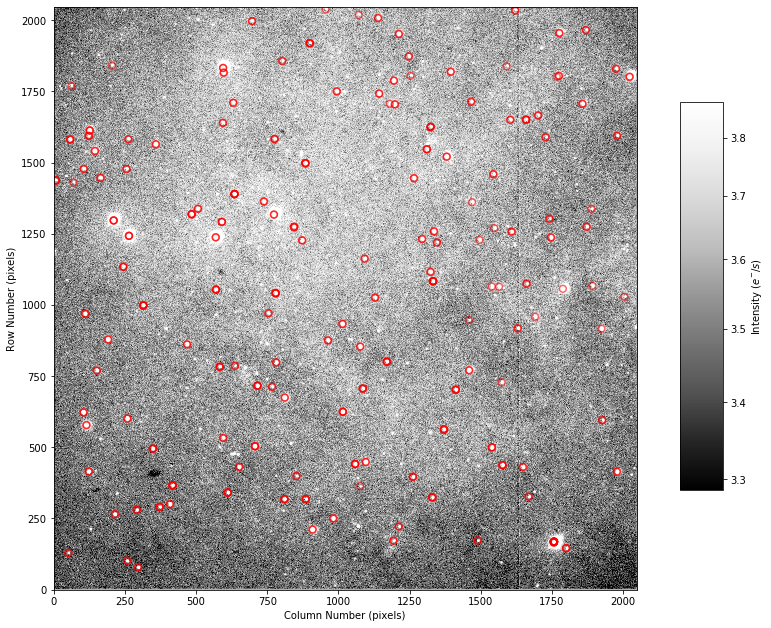

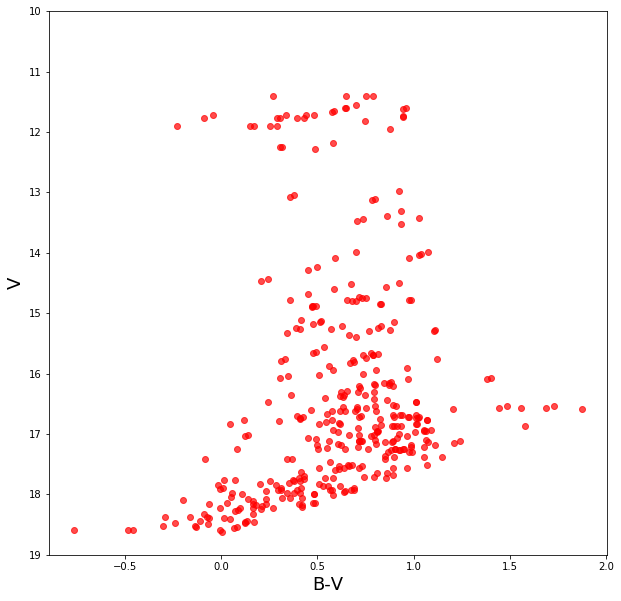

In [46]:
make_CMD(img_nova_B, imgwcs_nova_B, srcs_nova_B,imgwcs_nova_V, srcs_nova_V, hdr_nova_B, hdr_nova_V, ZPB_nova, ZPV_nova, radasec = 1.0)

Found 575/627 stars within 1.0 arcsec


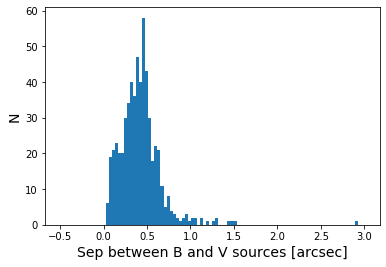

In [47]:
make_CMD(img_ngc7128_B, imgwcs_ngc7128_B, srcs_ngc7128_B,imgwcs_ngc7128_V, srcs_ngc7128_V, hdr_ngc7128_B, hdr_ngc7128_V, ZPB_ngc7128, ZPV_ngc7128, radasec = 1.0)